<a href="https://colab.research.google.com/github/hbisgin/DeepLearning/blob/main/DL_9_Q.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torch.nn.functional as F
from torch.utils.data import *
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import time


<Axes: >

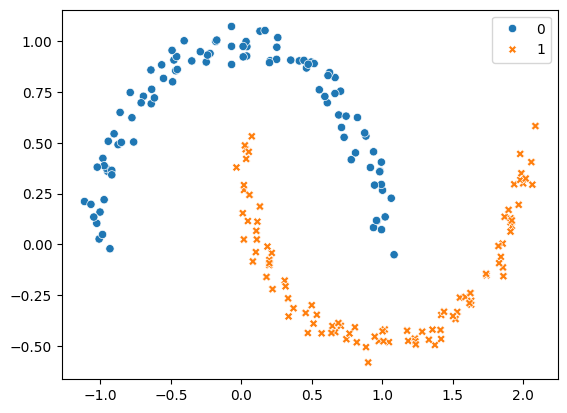

In [2]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=200, noise=0.05)
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, style=y)

In [3]:
classification_dataset = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long))
training_loader = DataLoader(classification_dataset)

In [4]:
in_features = 2
out_features = 2
model = nn.Linear(in_features, out_features)

In [5]:
def train_simple_network(model, loss_func, training_loader, epochs=20, device="cpu"):
    #Yellow step is done here. We create the optimizer and move the model to the compute device
    #SGD is Stochastic Gradient Decent over the parameters $\Theta$
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)
    #The next two for loops handle the Red steps, iterating through all the data (batches) multiple times (epochs)
    for epoch in tqdm(range(epochs), desc="Epoch"):

        model = model.train()#Put our model in training mode
        running_loss = 0.0

        for inputs, labels in tqdm(training_loader, desc="Batch", leave=False):
            #Move the batch of data to the device we are using. this is the last red step
            inputs = inputs.to(device)
            labels = labels.to(device)

            #First a yellow step, prepare the optimizer. Most PyTorch code will do this first to make sure everything is in a clean and ready state.

            #PyTorch stores gradients in a mutable data structure. So we need to set it to a clean state before we use it.
            #Otherwise, it will have old information from a previous iteration
            optimizer.zero_grad()

            #The next two lines of code perform the two blue steps
            y_hat = model(inputs) #this just computed $f_\theta(\boldsymbol{x_i})

            # Compute loss.
            loss = loss_func(y_hat, labels)

            #Now the remaining two yellow steps, compute the gradient and ".step()" the optimizer
            loss.backward()# $\nabla_\Theta$ just got computed by this one call

            #Now we just need to update all the parameters
            optimizer.step()# $\Theta_{k+1} = \Theta_k − \eta \cdot \nabla_\Theta \ell(\hat{y}, y)$

            #Now we are just grabbing some information we would like to have
            running_loss += loss.item()
        if epoch==1:
          print(y_hat, nn.functional.softmax(y_hat, dim=1))
          break

In [6]:
loss_func = nn.CrossEntropyLoss()
train_simple_network(model, loss_func, training_loader, epochs=50)

Epoch:   2%|▋                                    | 1/50 [00:00<00:12,  3.78it/s]

tensor([[ 0.2126, -0.1053]], grad_fn=<AddmmBackward0>) tensor([[0.5788, 0.4212]], grad_fn=<SoftmaxBackward0>)


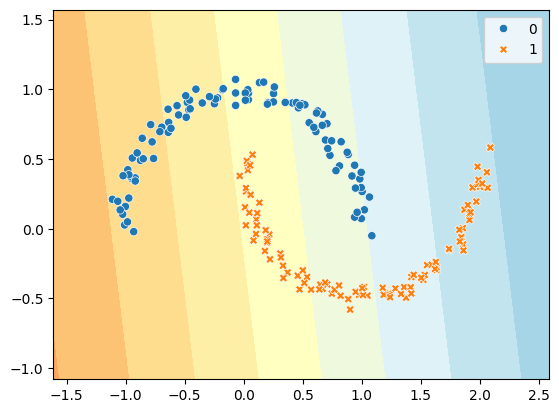

In [7]:
def visualize2DSoftmax(X, y, model, title=None):
    x_min = np.min(X[:,0])-0.5
    x_max = np.max(X[:,0])+0.5
    y_min = np.min(X[:,1])-0.5
    y_max = np.max(X[:,1])+0.5
    xv, yv = np.meshgrid(np.linspace(x_min, x_max, num=20), np.linspace(y_min, y_max, num=20), indexing='ij')
    xy_v = np.hstack((xv.reshape(-1,1), yv.reshape(-1,1)))
    with torch.no_grad():
        logits = model(torch.tensor(xy_v, dtype=torch.float32))
        y_hat = F.softmax(logits, dim=1).numpy()

    cs = plt.contourf(xv, yv, y_hat[:,0].reshape(20,20), levels=np.linspace(0,1,num=20), cmap=plt.cm.RdYlBu)
    ax = plt.gca()
    sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, style=y, ax=ax)
    if title is not None:
        ax.set_title(title)

visualize2DSoftmax(X, y, model)

#Let's change the network architecture a bit

In [8]:
model = nn.Sequential(
    nn.Linear(2,  30),
    nn.Tanh(),
    nn.Linear(30,  30),
    nn.Tanh(),
    nn.Linear(30, 2),
)
train_simple_network(model, loss_func, training_loader, epochs=50)

Epoch:   2%|▋                                    | 1/50 [00:00<00:13,  3.71it/s]

tensor([[-0.0773, -0.0274]], grad_fn=<AddmmBackward0>) tensor([[0.4875, 0.5125]], grad_fn=<SoftmaxBackward0>)


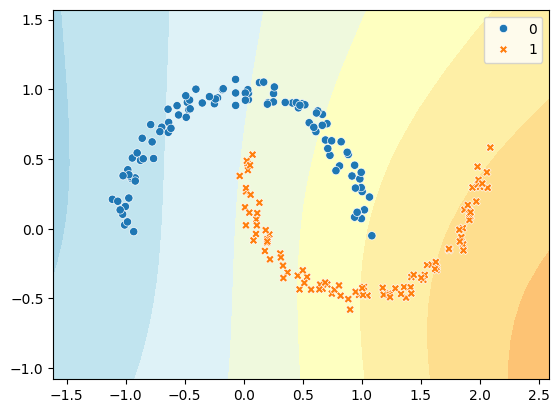

In [9]:
visualize2DSoftmax(X, y, model)

In [10]:
classification_dataset = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32))
training_loader = DataLoader(classification_dataset)

In [11]:
def train_simple_network_bce_logits(model, loss_func, training_loader, epochs=20, device="cpu"):
    #Yellow step is done here. We create the optimizer and move the model to the compute device
    #SGD is Stochastic Gradient Decent over the parameters $\Theta$
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)
    #The next two for loops handle the Red steps, iterating through all the data (batches) multiple times (epochs)
    for epoch in tqdm(range(epochs), desc="Epoch"):

        model = model.train()#Put our model in training mode
        running_loss = 0.0

        for inputs, labels in tqdm(training_loader, desc="Batch", leave=False):
            #Move the batch of data to the device we are using. this is the last red step
            inputs = inputs.to(device)
            labels = labels.to(device)

            #First a yellow step, prepare the optimizer. Most PyTorch code will do this first to make sure everything is in a clean and ready state.

            #PyTorch stores gradients in a mutable data structure. So we need to set it to a clean state before we use it.
            #Otherwise, it will have old information from a previous iteration
            optimizer.zero_grad()

            #The next two lines of code perform the two blue steps
            y_hat = model(inputs) #this just computed $f_\theta(\boldsymbol{x_i})
            print(y_hat.shape, labels.shape)

            # Compute loss.
            loss = loss_func(y_hat.view(-1,1), labels.view(-1,1))

            #Now the remaining two yellow steps, compute the gradient and ".step()" the optimizer
            loss.backward()# $\nabla_\Theta$ just got computed by this one call

            #Now we just need to update all the parameters
            optimizer.step()# $\Theta_{k+1} = \Theta_k − \eta \cdot \nabla_\Theta \ell(\hat{y}, y)$

            #Now we are just grabbing some information we would like to have
            running_loss += loss.item()
        if epoch==1:
          print(y_hat, nn.functional.softmax(y_hat, dim=1))
          break

In [12]:
model = nn.Sequential(
    nn.Linear(2,  30),
    nn.Tanh(),
    nn.Linear(30,  30),
    nn.Tanh(),
    nn.Linear(30, 1),
)
loss_func = nn.BCEWithLogitsLoss()
train_simple_network_bce_logits(model, loss_func, training_loader, epochs=50)

Epoch:   2%|▋                                    | 1/50 [00:00<00:07,  6.83it/s]

torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) t


Batch:   0%|                                            | 0/200 [00:00<?, ?it/s]

torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) t


Epoch:   2%|▋                                    | 1/50 [00:00<00:14,  3.35it/s]

torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) torch.Size([1])
torch.Size([1, 1]) t

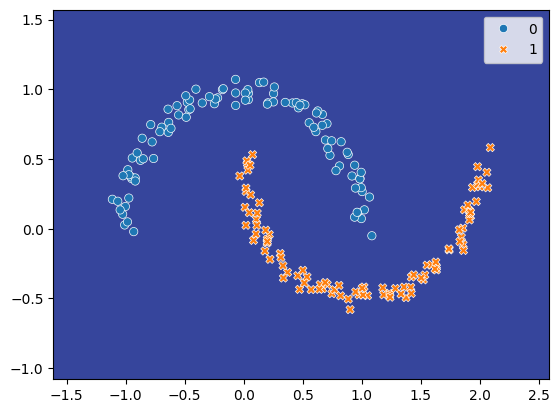

In [13]:
visualize2DSoftmax(X, y, model)

# Using BCELoss

In [14]:
import torch
import torch.nn as nn
from tqdm import tqdm

def train_simple_network_bce(model, loss_func, training_loader, epochs=20, device="cpu"):
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
    model.to(device)

    for epoch in tqdm(range(epochs), desc="Epoch"):
        model.train()
        running_loss = 0.0

        for inputs, labels in tqdm(training_loader, desc="Batch", leave=False):
            inputs = inputs.to(device)

            # BCELoss needs float targets (0/1) and matching shape
            labels = labels.to(device).view(-1, 1)

            optimizer.zero_grad()

            logits = model(inputs)                  # raw output, shape [B,1] usually
            probs  = torch.sigmoid(logits)          # <-- KEY CHANGE for BCELoss

            loss = loss_func(probs, labels)         # <-- pass probs, not logits

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / max(1, len(training_loader))
        tqdm.write(f"Epoch {epoch+1}/{epochs} - loss: {avg_loss:.4f}")


In [15]:
model = nn.Sequential(
    nn.Linear(2,  30),
    nn.Tanh(),
    nn.Linear(30,  30),
    nn.Tanh(),
    nn.Linear(30, 1),
)
loss_func = nn.BCELoss()
train_simple_network_bce(model, loss_func, training_loader, epochs=50)

Epoch:   2%|▋                                    | 1/50 [00:00<00:07,  6.76it/s]

Epoch 1/50 - loss: 0.7327



Epoch:   4%|█▍                                   | 2/50 [00:00<00:07,  6.84it/s]

Epoch 2/50 - loss: 0.7069



Epoch:   6%|██▏                                  | 3/50 [00:00<00:06,  6.82it/s]

Epoch 3/50 - loss: 0.6839



Epoch:   8%|██▉                                  | 4/50 [00:00<00:06,  6.90it/s]

Epoch 4/50 - loss: 0.6626



Epoch:  10%|███▋                                 | 5/50 [00:00<00:06,  6.85it/s]

Epoch 5/50 - loss: 0.6422



Epoch:  12%|████▍                                | 6/50 [00:00<00:06,  6.86it/s]

Epoch 6/50 - loss: 0.6223



Epoch:  14%|█████▏                               | 7/50 [00:01<00:06,  6.86it/s]

Epoch 7/50 - loss: 0.6026



Epoch:  16%|█████▉                               | 8/50 [00:01<00:06,  6.87it/s]

Epoch 8/50 - loss: 0.5830



Epoch:  18%|██████▋                              | 9/50 [00:01<00:06,  6.41it/s]

Epoch 9/50 - loss: 0.5635



Epoch:  20%|███████▏                            | 10/50 [00:01<00:06,  6.63it/s]

Epoch 10/50 - loss: 0.5442



Epoch:  22%|███████▉                            | 11/50 [00:01<00:05,  6.70it/s]

Epoch 11/50 - loss: 0.5252



Epoch:  24%|████████▋                           | 12/50 [00:01<00:05,  6.78it/s]

Epoch 12/50 - loss: 0.5067



Epoch:  26%|█████████▎                          | 13/50 [00:01<00:05,  6.75it/s]

Epoch 13/50 - loss: 0.4888



Epoch:  28%|██████████                          | 14/50 [00:02<00:05,  6.80it/s]

Epoch 14/50 - loss: 0.4718



Epoch:  30%|██████████▊                         | 15/50 [00:02<00:05,  6.84it/s]

Epoch 15/50 - loss: 0.4557



Epoch:  32%|███████████▌                        | 16/50 [00:02<00:04,  6.88it/s]

Epoch 16/50 - loss: 0.4407



Epoch:  34%|████████████▏                       | 17/50 [00:02<00:04,  6.86it/s]

Epoch 17/50 - loss: 0.4268



Epoch:  36%|████████████▉                       | 18/50 [00:02<00:04,  6.88it/s]

Epoch 18/50 - loss: 0.4139



Epoch:  38%|█████████████▋                      | 19/50 [00:02<00:04,  6.88it/s]

Epoch 19/50 - loss: 0.4021



Epoch:  40%|██████████████▍                     | 20/50 [00:02<00:04,  6.86it/s]

Epoch 20/50 - loss: 0.3913



Epoch:  42%|███████████████                     | 21/50 [00:03<00:04,  6.83it/s]

Epoch 21/50 - loss: 0.3814



Epoch:  44%|███████████████▊                    | 22/50 [00:03<00:04,  6.89it/s]

Epoch 22/50 - loss: 0.3723



Epoch:  46%|████████████████▌                   | 23/50 [00:03<00:03,  6.98it/s]

Epoch 23/50 - loss: 0.3640



Epoch:  48%|█████████████████▎                  | 24/50 [00:03<00:03,  7.00it/s]

Epoch 24/50 - loss: 0.3564



Epoch:  50%|██████████████████                  | 25/50 [00:03<00:03,  6.94it/s]

Epoch 25/50 - loss: 0.3494



Epoch:  52%|██████████████████▋                 | 26/50 [00:03<00:03,  6.73it/s]

Epoch 26/50 - loss: 0.3430



Epoch:  54%|███████████████████▍                | 27/50 [00:03<00:03,  6.62it/s]

Epoch 27/50 - loss: 0.3371



Epoch:  56%|████████████████████▏               | 28/50 [00:04<00:03,  6.58it/s]

Epoch 28/50 - loss: 0.3316



Epoch:  58%|████████████████████▉               | 29/50 [00:04<00:03,  6.55it/s]

Epoch 29/50 - loss: 0.3265



Epoch:  60%|█████████████████████▌              | 30/50 [00:04<00:03,  6.56it/s]

Epoch 30/50 - loss: 0.3218



Epoch:  62%|██████████████████████▎             | 31/50 [00:04<00:02,  6.71it/s]

Epoch 31/50 - loss: 0.3174



Epoch:  64%|███████████████████████             | 32/50 [00:04<00:02,  6.86it/s]

Epoch 32/50 - loss: 0.3132



Epoch:  66%|███████████████████████▊            | 33/50 [00:04<00:02,  6.77it/s]

Epoch 33/50 - loss: 0.3094



Epoch:  68%|████████████████████████▍           | 34/50 [00:05<00:02,  6.77it/s]

Epoch 34/50 - loss: 0.3058



Epoch:  70%|█████████████████████████▏          | 35/50 [00:05<00:02,  6.85it/s]

Epoch 35/50 - loss: 0.3024



Epoch:  72%|█████████████████████████▉          | 36/50 [00:05<00:02,  6.89it/s]

Epoch 36/50 - loss: 0.2992



Epoch:  74%|██████████████████████████▋         | 37/50 [00:05<00:01,  6.87it/s]

Epoch 37/50 - loss: 0.2962



Epoch:  76%|███████████████████████████▎        | 38/50 [00:05<00:01,  6.83it/s]

Epoch 38/50 - loss: 0.2934



Epoch:  78%|████████████████████████████        | 39/50 [00:05<00:01,  6.80it/s]

Epoch 39/50 - loss: 0.2908



Epoch:  80%|████████████████████████████▊       | 40/50 [00:05<00:01,  6.89it/s]

Epoch 40/50 - loss: 0.2883



Epoch:  82%|█████████████████████████████▌      | 41/50 [00:06<00:01,  6.99it/s]

Epoch 41/50 - loss: 0.2860



Epoch:  84%|██████████████████████████████▏     | 42/50 [00:06<00:01,  7.07it/s]

Epoch 42/50 - loss: 0.2838



Epoch:  86%|██████████████████████████████▉     | 43/50 [00:06<00:00,  7.11it/s]

Epoch 43/50 - loss: 0.2818



Epoch:  88%|███████████████████████████████▋    | 44/50 [00:06<00:00,  7.18it/s]

Epoch 44/50 - loss: 0.2798



Epoch:  90%|████████████████████████████████▍   | 45/50 [00:06<00:00,  7.18it/s]

Epoch 45/50 - loss: 0.2780



Epoch:  92%|█████████████████████████████████   | 46/50 [00:06<00:00,  7.15it/s]

Epoch 46/50 - loss: 0.2763



Epoch:  94%|█████████████████████████████████▊  | 47/50 [00:06<00:00,  7.14it/s]

Epoch 47/50 - loss: 0.2747



Epoch:  96%|██████████████████████████████████▌ | 48/50 [00:06<00:00,  7.18it/s]

Epoch 48/50 - loss: 0.2732



Epoch:  98%|███████████████████████████████████▎| 49/50 [00:07<00:00,  7.21it/s]

Epoch 49/50 - loss: 0.2718



Epoch: 100%|████████████████████████████████████| 50/50 [00:07<00:00,  6.88it/s]

Epoch 50/50 - loss: 0.2705


In [50]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pytorch_lightning as pl

iris = load_iris()
X = iris.data
y = iris.target
print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
training_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train_scaled, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
training_loader = DataLoader(training_dataset, batch_size=16, shuffle=True)
print(X_train_scaled.shape)
model = nn.Sequential(
    nn.Linear(4,  10),
    nn.ReLU(),
    nn.Linear(10,  10),
    nn.ReLU(),
    nn.Linear(10, 3),
)
loss_func = nn.CrossEntropyLoss()
train_simple_network_ce(model, loss_func, training_loader, epochs=50, device="cpu")



(150, 4) (150,)
(112, 4)


Epoch:   0%|                                             | 0/50 [00:00<?, ?it/s]

Epoch 1/50 - loss: 1.1560



Epoch:   0%|                                             | 0/50 [00:00<?, ?it/s]

Epoch 2/50 - loss: 1.1548



Epoch:   0%|                                             | 0/50 [00:00<?, ?it/s]

Epoch 3/50 - loss: 1.1535



Epoch:   0%|                                             | 0/50 [00:00<?, ?it/s]

Epoch 4/50 - loss: 1.1522



Epoch:  10%|███▋                                 | 5/50 [00:00<00:01, 32.28it/s]

Epoch 5/50 - loss: 1.1510



Epoch:  10%|███▋                                 | 5/50 [00:00<00:01, 32.28it/s]

Epoch 6/50 - loss: 1.1497



Epoch:  10%|███▋                                 | 5/50 [00:00<00:01, 32.28it/s]

Epoch 7/50 - loss: 1.1484



Epoch:  10%|███▋                                 | 5/50 [00:00<00:01, 32.28it/s]

Epoch 8/50 - loss: 1.1472



Epoch:  18%|██████▋                              | 9/50 [00:00<00:01, 35.63it/s]

Epoch 9/50 - loss: 1.1459



Epoch:  18%|██████▋                              | 9/50 [00:00<00:01, 35.63it/s]

Epoch 10/50 - loss: 1.1447



Epoch:  18%|██████▋                              | 9/50 [00:00<00:01, 35.63it/s]

Epoch 11/50 - loss: 1.1435



Epoch:  18%|██████▋                              | 9/50 [00:00<00:01, 35.63it/s]

Epoch 12/50 - loss: 1.1422



Epoch:  18%|██████▋                              | 9/50 [00:00<00:01, 35.63it/s]

Epoch 13/50 - loss: 1.1410



Epoch:  28%|██████████                          | 14/50 [00:00<00:00, 37.90it/s]

Epoch 14/50 - loss: 1.1398



Epoch:  28%|██████████                          | 14/50 [00:00<00:00, 37.90it/s]

Epoch 15/50 - loss: 1.1386



Epoch:  28%|██████████                          | 14/50 [00:00<00:00, 37.90it/s]

Epoch 16/50 - loss: 1.1374



Epoch:  28%|██████████                          | 14/50 [00:00<00:00, 37.90it/s]

Epoch 17/50 - loss: 1.1362



Epoch:  36%|████████████▉                       | 18/50 [00:00<00:00, 36.22it/s]

Epoch 18/50 - loss: 1.1349



Epoch:  36%|████████████▉                       | 18/50 [00:00<00:00, 36.22it/s]

Epoch 19/50 - loss: 1.1337



Epoch:  36%|████████████▉                       | 18/50 [00:00<00:00, 36.22it/s]

Epoch 20/50 - loss: 1.1326



Epoch:  36%|████████████▉                       | 18/50 [00:00<00:00, 36.22it/s]

Epoch 21/50 - loss: 1.1314



Epoch:  44%|███████████████▊                    | 22/50 [00:00<00:00, 35.49it/s]

Epoch 22/50 - loss: 1.1302



Epoch:  44%|███████████████▊                    | 22/50 [00:00<00:00, 35.49it/s]

Epoch 23/50 - loss: 1.1289



Epoch:  44%|███████████████▊                    | 22/50 [00:00<00:00, 35.49it/s]

Epoch 24/50 - loss: 1.1278



Epoch:  44%|███████████████▊                    | 22/50 [00:00<00:00, 35.49it/s]

Epoch 25/50 - loss: 1.1266



Epoch:  52%|██████████████████▋                 | 26/50 [00:00<00:00, 34.77it/s]

Epoch 26/50 - loss: 1.1254



Epoch:  52%|██████████████████▋                 | 26/50 [00:00<00:00, 34.77it/s]

Epoch 27/50 - loss: 1.1242



Epoch:  52%|██████████████████▋                 | 26/50 [00:00<00:00, 34.77it/s]

Epoch 28/50 - loss: 1.1230



Epoch:  52%|██████████████████▋                 | 26/50 [00:00<00:00, 34.77it/s]

Epoch 29/50 - loss: 1.1219



Batch:   0%|                                              | 0/7 [00:00<?, ?it/s]


Epoch 30/50 - loss: 1.1207


Epoch:  52%|██████████████████▋                 | 26/50 [00:00<00:00, 34.77it/s]

Epoch 31/50 - loss: 1.1195



Epoch:  64%|███████████████████████             | 32/50 [00:00<00:00, 40.19it/s]

Epoch 32/50 - loss: 1.1184



Epoch:  64%|███████████████████████             | 32/50 [00:00<00:00, 40.19it/s]

Epoch 33/50 - loss: 1.1172



Epoch:  64%|███████████████████████             | 32/50 [00:00<00:00, 40.19it/s]

Epoch 34/50 - loss: 1.1161



Epoch:  64%|███████████████████████             | 32/50 [00:00<00:00, 40.19it/s]

Epoch 35/50 - loss: 1.1149



Epoch:  64%|███████████████████████             | 32/50 [00:00<00:00, 40.19it/s]

Epoch 36/50 - loss: 1.1137



Epoch:  64%|███████████████████████             | 32/50 [00:00<00:00, 40.19it/s]

Epoch 37/50 - loss: 1.1126



Epoch:  76%|███████████████████████████▎        | 38/50 [00:00<00:00, 43.96it/s]

Epoch 38/50 - loss: 1.1114



Epoch:  76%|███████████████████████████▎        | 38/50 [00:00<00:00, 43.96it/s]

Epoch 39/50 - loss: 1.1103



Epoch:  76%|███████████████████████████▎        | 38/50 [00:01<00:00, 43.96it/s]

Epoch 40/50 - loss: 1.1091



Epoch:  76%|███████████████████████████▎        | 38/50 [00:01<00:00, 43.96it/s]

Epoch 41/50 - loss: 1.1080



Epoch:  76%|███████████████████████████▎        | 38/50 [00:01<00:00, 43.96it/s]

Epoch 42/50 - loss: 1.1068



Epoch:  76%|███████████████████████████▎        | 38/50 [00:01<00:00, 43.96it/s]

Epoch 43/50 - loss: 1.1057



Epoch:  88%|███████████████████████████████▋    | 44/50 [00:01<00:00, 46.30it/s]

Epoch 44/50 - loss: 1.1046



Epoch:  88%|███████████████████████████████▋    | 44/50 [00:01<00:00, 46.30it/s]

Epoch 45/50 - loss: 1.1034



Epoch:  88%|███████████████████████████████▋    | 44/50 [00:01<00:00, 46.30it/s]

Epoch 46/50 - loss: 1.1023



Epoch:  88%|███████████████████████████████▋    | 44/50 [00:01<00:00, 46.30it/s]

Epoch 47/50 - loss: 1.1011



Epoch:  88%|███████████████████████████████▋    | 44/50 [00:01<00:00, 46.30it/s]

Epoch 48/50 - loss: 1.1000



Epoch:  98%|███████████████████████████████████▎| 49/50 [00:01<00:00, 43.22it/s]

Epoch 49/50 - loss: 1.0989



Epoch: 100%|████████████████████████████████████| 50/50 [00:01<00:00, 40.42it/s]

Epoch 50/50 - loss: 1.0977


In [48]:
def train_simple_network_ce(model, loss_func, training_loader, epochs=20, device="cpu"):
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
    model.to(device)

    for epoch in tqdm(range(epochs), desc="Epoch"):
        model.train()
        running_loss = 0.0

        for inputs, labels in tqdm(training_loader, desc="Batch", leave=False):
            inputs = inputs.to(device)

            # BCELoss needs float targets (0/1) and matching shape
            labels = labels.to(device)

            optimizer.zero_grad()

            logits = model(inputs)                  # raw output, shape [B,1] usually
           
            loss = loss_func(logits, labels)         

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / max(1, len(training_loader))
        tqdm.write(f"Epoch {epoch+1}/{epochs} - loss: {avg_loss:.4f}")

#Can you try one of the network desings and training functions to predict the species of iris flowers? Please feel free to use your earlier notebooks for dataloader generation if needed.